In [68]:
from __future__ import print_function 
import os 
from enum import Enum
from textwrap import wrap
import locale
import pandas as pd 
import numpy as np 

%matplotlib inline 
from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates

from pandas.plotting import autocorrelation_plot

locale.setlocale(locale.LC_ALL, '')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [34]:
# 
# Some common functions.
# 
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(False)
        axe.spines['left'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

# 
global_statistics = {
     "duration": None
    ,"max threads": None
}
dec_num = 2
ok_codes = [200, 202]

# Titles and labels.
it = {
     "thread title": ("Numero thread", 14)
    ,"thread x":     ("Tempo", 12)
    ,"thread y":     ("Numero", 12)
    
    ,"elapsed title":      ("Tempo di servizio", 14)
    ,"elapsed title - log":("Tempo di servizio - scala logaritmica", 14)
    ,"elapsed x":          ("Tempo", 12)
    ,"elapsed y":          ("Tempo di servizio (ms)", 12)

    ,"elapsed-binned title":      ("Tempo di servizio medio", 14)
    ,"elapsed-binned title - log":("Tempo di servizio medio - scala logaritmica", 14)
    ,"elapsed-binned x":          ("Tempo", 12)
    ,"elapsed-binned y":          ("Tempo di servizio medio (ms)", 12)
    ,"elapsed-binned mean txt":   ("Tempo servizio medio", 12)
    ,"elapsed-binned snum y":     ("Numero campioni", 12)

    ,"elapsed-frequency title":   ("Analisi frequenza dei tempi di servizio", 12)
    ,"elapsed-frequency label":   ("Frequenza", 12)
    ,"elapsed-frequency y %":     ("Percentuale", 12)
    ,"elapsed-frequency y #":     ("Numero", 12)
    ,"elapsed-frequency y":       ("", 12)
    ,"elapsed-frequency x":       ("Intervallo tempo di servizio (ms)", 12)

    ,"tps title":                 ("Transazioni per secondo", 12)
    ,"tps label":                 ("Frequenza", 12)
    ,"tps y":                     ("Transazioni per secondo", 12)
    ,"tps x":                     ("Tempo", 12)
    
    ,"quantiles txt title":       ("Tabella percentile / valore", 12)
    ,"statistics txt title":      ("Dati statistici:", 12)
    ,"stats duration":            ("Inizio test: {be}\nFine test: {en}\nDurata: {d} (minuti)\n")
    ,"stats sample num":          ("Numero campioni: {n}\nCampioni in errore: {er}\n")

    ,"stats elapsed":             ("Tempo di servizio minimo: {min} (ms)\nTempo di servizio massimo: {max} (ms)\nTempo di servizio medio: {avg} (ms)\nVarianza: {stde} (ms)\n Tempo di servizio - mediana: {med} (ms)\n")
    ,"stats max threads":         ("Numero massimo di thread: {th} (ms)\n")
}
en = {
     "thread title": ("Threads number", 14)
    ,"thread x":     ("Time", 12)
    ,"thread y":     ("Number", 12)

    ,"elapsed title":      ("Service time", 14)
    ,"elapsed title - log":("Service time - logarithmic scale", 12)
    ,"elapsed x":          ("Time", 12)
    ,"elapsed y":          ("Service time (ms)", 12)
    
    ,"elapsed-binned title":      ("Average service time", 14)
    ,"elapsed-binned title - log":("Average service time - logarithmic scale", 12)
    ,"elapsed-binned x":          ("Ttime", 12)
    ,"elapsed-binned y":          ("Average service time (ms)", 12)
    ,"elapsed-binned mean txt":   ("Elapsed mean value", 12)
    ,"elapsed-binned snum y":     ("Sample numerosity", 12)

    ,"elapsed-frequency title":   ("Elapsed time frequency analisys", 12)
    ,"elapsed-frequency label":   ("Frequency", 12)  
    ,"elapsed-frequency y %":     ("Percentage", 12)
    ,"elapsed-frequency y #":     ("Number of samples", 12)
    ,"elapsed-frequency y":       ("", 12)
    ,"elapsed-frequency x":       ("Elapsed (ms)", 12)

    ,"tps title":                 ("Transaction per second", 12)
    ,"tps label":                 ("", 12)
    ,"tps y":                     ("Transaction per second", 12)
    ,"tps x":                     ("Time", 12)
    
    ,"quantiles txt title":       ("Quantiles / value table", 12)
    ,"statistics txt title":      ("Statistics:", 12)
    
    ,"stats duration":            ("Begin datetime: {be}\nEnd datetime: {en}\nDuration: {d} (minuti)\n")
    ,"stats sample num":          ("Number of samples: {n}\nSamples in error: {er}\n")

    ,"stats elapsed":             ("Elapsed min: {min} (ms)\nElapsed max: {max} (ms)\nElapsed mean: {avg} (ms)\nStandard error: {stde} (ms)\nElapsed median: {med} (ms)\n")
    ,"stats max threads":         ("Max threads num: {th} (ms)\n")
}
labels = en

In [69]:
images_path = os.path.join("..","images")

data_file_path = "/tmp"
data_file_name = "MvtC2CGateway-C2C-only_20180516_153201-.jtl"

image_file_prefix = "Test-"
picture_title = "Load test of XYZ "

class TypeOfChart(Enum):
    PERCENTAGE = 1
    FREQUENCIES = 2

type_of_elapsed_frequency_chart = TypeOfChart.PERCENTAGE

data_file = os.path.join(data_file_path, data_file_name)

In [48]:
dtype_dict = {
}

parse_dates = ["timeStamp"]

columns = ["elapsed", "responseCode", "responseMessage","grpThreads","allThreads"]

df = pd.read_csv(data_file, sep='#', lineterminator='\n'
                ,low_memory=False
                ,dtype=dtype_dict)
df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit='ms')
df.set_index("timeStamp", inplace=True)
df.sort_index(axis=0, ascending=True, inplace=True)
#df.sort_values(by=["timeStamp"], inplace=True)

# Get just the columns we need.
df = df[columns]

# Collection of all the sample in error.
errors_df = df.loc[~ df['responseCode'].isin(ok_codes)]

# Create a dataframe binned and with the average elapsed value and bin size.
minutes = 'T'
time_delta = 30
time_unit = 'S'
td_for_grouper = '{td}{tu}'.format(td=str(time_delta), tu=time_unit) 

binned_elapsed = df.groupby(pd.Grouper(level='timeStamp', freq=td_for_grouper))['elapsed'].agg(['mean','count']) 
binned_elapsed["dt centered"] = binned_elapsed.index  + pd.offsets.Second(15)

# Calculate the transaction per second for each bin.
if time_unit != 'S':
    assert False, "Only seconds are managed by the code."

binned_elapsed['tps'] = binned_elapsed['count'].apply(lambda row: row/time_delta)

#(df_red.shape, df_red.dtypes)
df.head(2)

,elapsed,responseCode,responseMessage,grpThreads,allThreads
timeStamp,,,,,
2018-05-16 15:32:03.967,125,200,OK,1,1
2018-05-16 15:32:04.100,22,200,OK,1,1


In [49]:
# Calculate the test duration in minutes.
global_statistics["test begin"] = df.index.min()
global_statistics["test end"] = df.index.max()
duration = global_statistics["test end"] - global_statistics["test begin"]

global_statistics["duration"] = round(duration.total_seconds() / 60, dec_num)
global_statistics["duration sec"] = duration.total_seconds()

# Max number of threads.
global_statistics["max threads"] = df["allThreads"].max()

# Total transaction per second.
global_statistics["transaction per second"] = (df.shape[0] - errors_df.shape[0])/global_statistics["duration sec"]
global_statistics["transaction per second"] = round(global_statistics["transaction per second"], 0)

# Sample len.
global_statistics["sample num"] = df.shape[0]
global_statistics["samples in error"] = errors_df.shape[0]

# Service time statistics.
global_statistics["max elapsed"] = df["elapsed"].max()
global_statistics["min elapsed"] = df["elapsed"].min()
global_statistics["mean elapsed"] = round(df["elapsed"].mean(), dec_num)
global_statistics["median elapsed"] = round(df["elapsed"].median(), dec_num)
global_statistics["std error elapsed"] = round(df["elapsed"].sem(), dec_num)
global_statistics["quantiles elapsed"] = df["elapsed"].quantile(np.arange(0, 1, 0.1))

# Total transactions (sample not in error per second).
global_statistics["quantiles elapsed"]

time_limits = [global_statistics["test begin"] - pd.Timedelta(minutes=0.5) 
              ,global_statistics["test end"] + pd.Timedelta(minutes=0.5)]

global_statistics

{'duration': 15.0,
 'max threads': 150,
 'test begin': Timestamp('2018-05-16 15:32:03.967000'),
 'test end': Timestamp('2018-05-16 15:47:03.839000'),
 'duration sec': 899.872,
 'transaction per second': 118.0,
 'sample num': 106622,
 'samples in error': 0,
 'max elapsed': 3359,
 'min elapsed': 12,
 'mean elapsed': 843.23,
 'median elapsed': 683.0,
 'std error elapsed': 2.15,
 'quantiles elapsed': 0.0      12.0
 0.1      77.0
 0.2     203.0
 0.3     387.0
 0.4     553.0
 0.5     683.0
 0.6     803.0
 0.7    1016.0
 0.8    1366.0
 0.9    2123.0
 Name: elapsed, dtype: float64}

In [50]:
df['responseCode'].value_counts().loc[200]
#~
df.loc[~ df['responseCode'].isin(ok_codes)].shape[0]


0

In [20]:
#
#
#

def threads_chart(ax, x, y, color):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
    
        ax.step(x, y, color=color)
        ax.set_xlim(time_limits)
    
        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        #seconds = mdates.SecondLocator(bysecond = 30)
        #seconds_fmt = mdates.DateFormatter('%S')
 
        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)

        #ax.xaxis.set_minor_locator(seconds)
        #ax.xaxis.set_minor_formatter(seconds_fmt)
        
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        ax.set_title(labels['thread title'][0], fontsize=labels['thread title'][1])
        ax.set_ylabel(labels["thread y"][0],    fontsize=labels['thread y'][1])
        ax.set_xlabel(labels["thread x"][0],    fontsize=labels['thread x'][1])

    except Exception as ex:
        print("threads_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


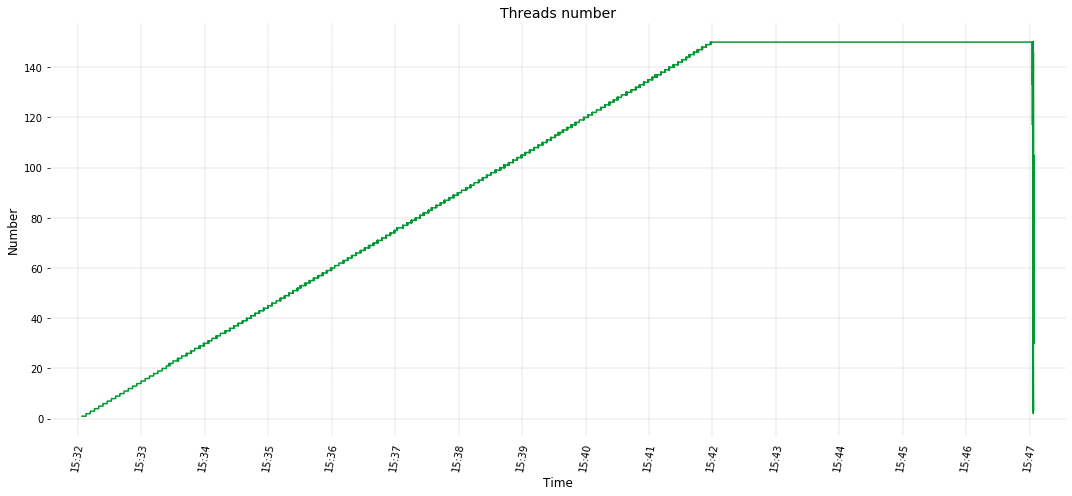

In [21]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)


ax = []
ax.append(fig.add_subplot(gs[0, 0]))

threads_chart(ax[0], df.index, df["allThreads"], color="#009933")

plt.savefig(os.path.join(images_path,"{prefix}threads_chart.png".format(prefix=image_file_prefix)))



In [22]:
#
#
#

def elapsed_chart(ax, x, y, errors=[None, None], colors=["#0000e6", "#ff1a1a"], logarithmic=False):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
        ax.set_xlim(time_limits)

        ax.scatter(x, y, color=colors[0], s=3)
        if errors is not None and errors[0].shape[0] > 0 and errors[0].shape[0] == errors[1].shape[0]:
            ax.scatter(errors[0], errors[1], color=colors[1], s=3)
    
        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        if logarithmic:
            ax.set_yscale('log')
            ax.set_title(labels['elapsed title - log'][0], fontsize=labels['elapsed title - log'][1])
        else:
            ax.set_title(labels['elapsed title'][0], fontsize=labels['elapsed title'][1])
        
        ax.set_ylabel(labels["elapsed y"][0],    fontsize=labels['elapsed y'][1])
        ax.set_xlabel(labels["elapsed x"][0],    fontsize=labels['elapsed x'][1])
            
    except Exception as ex:
        print("elapsed_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


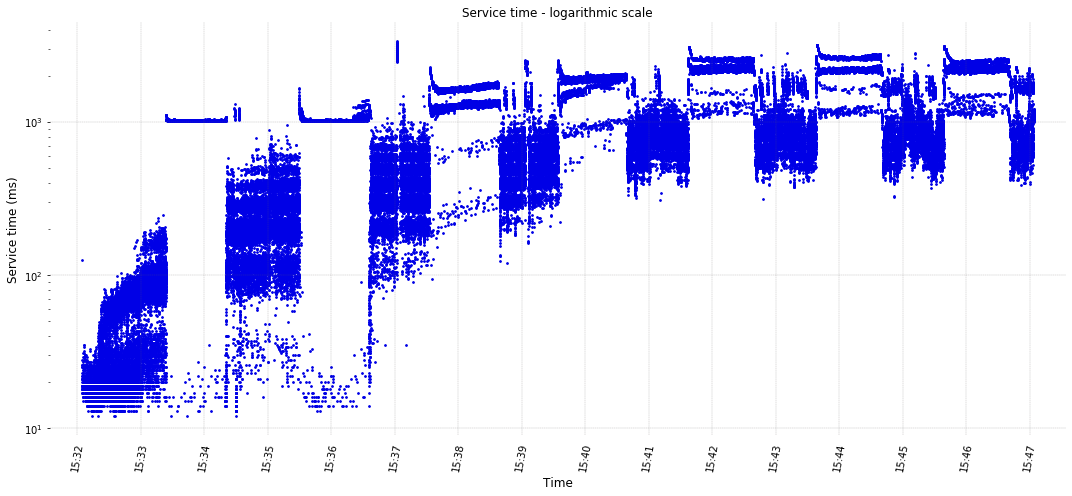

In [23]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

elapsed_chart(ax[0]
             ,x=df.index, y=df["elapsed"]
             ,errors=[errors_df.index, errors_df["elapsed"]]
             ,logarithmic=True)

plt.savefig(os.path.join(images_path,"{prefix}elapsed_chart.png".format(prefix=image_file_prefix)))


In [24]:
#
#
#

def elapsed_binned_chart(ax, x, y, x_snum, y_snum, colors=["#0000e6", "#d5d5d5", "#c87607"]):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
        ax.set_xlim(time_limits)

        ax.step(x, y, color=colors[0])
        ax.hlines(y=global_statistics["mean elapsed"]
                 ,xmin=time_limits[0], xmax=time_limits[1]
                 ,linewidth=2
                 ,color=colors[2])
        
        ax.text(x=time_limits[0]
               ,y=global_statistics["mean elapsed"] + 50
               ,s=labels["elapsed-binned mean txt"][0]
               ,color=colors[2]
               ,fontsize=labels["elapsed-binned mean txt"][1])

        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)
       
        ax.tick_params(axis='x', labelrotation=80)

        ax.set_title(labels['elapsed-binned title'][0], fontsize=labels['elapsed-binned title'][1])
        
        ax.set_ylabel(labels["elapsed-binned y"][0], fontsize=labels['elapsed-binned y'][1])
        ax.set_xlabel(labels["elapsed-binned x"][0], fontsize=labels['elapsed-binned x'][1])
        remove_tick_lines('x', ax)
        
        # Second y axis.
        ax_snum = ax.twinx()
        set_axes_common_properties(ax_snum, True)
        
        ax_snum.scatter(x_snum, y_snum, color=colors[1], s=50, alpha=0.9)
        
        ax_snum.set_ylabel(labels["elapsed-binned snum y"][0], fontsize=labels['elapsed-binned snum y'][1])

        ax_snum.xaxis.set_major_locator(minutes)
        ax_snum.xaxis.set_major_formatter(minutes_fmt)     
        ax_snum.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax_snum)
        remove_tick_lines('y', ax_snum)
        
    except Exception as ex:
        print("elapsed_binned_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


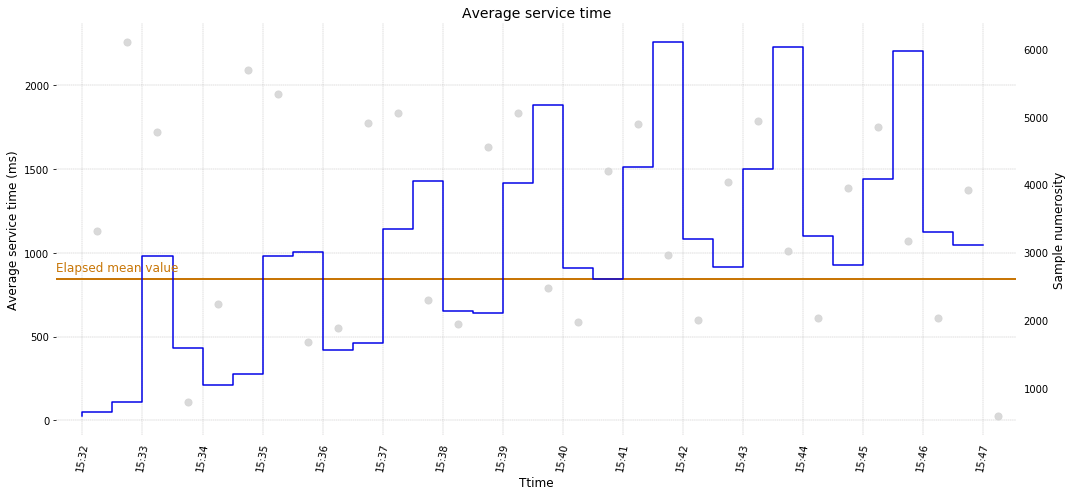

In [25]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

elapsed_binned_chart(ax[0]
                    ,x=binned_elapsed.index
                    ,y=binned_elapsed['mean']
                    ,x_snum=binned_elapsed["dt centered"]
                    ,y_snum=binned_elapsed['count'])

plt.savefig(os.path.join(images_path,"{prefix}elapsed_binned_chart.png".format(prefix=image_file_prefix)))


In [26]:
def elapsed_frequency_chart(ax, x, y, colors=["#BEE2F0", "#d5d5d5", "#c87607"]):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax)
        ax.set_title(labels["elapsed-frequency title"][0], fontsize=labels["elapsed-frequency title"][1])
        ax.set_ylabel(labels["elapsed-frequency y"][0], fontsize=labels["elapsed-frequency y"][1])
        ax.set_xlabel(labels["elapsed-frequency x"][0], fontsize=labels["elapsed-frequency x"][1])

        width = 0.5
        rects = ax.bar(x, y, width=width, color=colors[0], label=labels["elapsed-frequency label"][0])

        autolabel(rects, ax, 1)

        ax.tick_params(axis='both', labelsize=14)
        ax.set_xticklabels(x, rotation=80)

        remove_tick_lines('y', ax)
        remove_tick_lines('x', ax)
    
    except Exception as ex:
        print("elapsed_frequency_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv
 
def config_elapsed_frequency_chart(type_of_chart = TypeOfChart.PERCENTAGE):
    """
    
    """
    rv = False
    frequencies = None
    try:
        # Set the data set to be visualized.
        bin_step = 250
        cut_bins = list(range(0, global_statistics["max elapsed"], bin_step))
        bin_size = len(cut_bins)

        df['elapsed binned'] = pd.cut(df['elapsed'], bins=cut_bins, right=True)
        frequencies = df['elapsed binned'].value_counts(sort=False)

        # Quality check.
        #assert df.shape[0] == df['elapsed binned'].value_counts().sum(), "The aggregate form must have the same total number of the total num of sample."

        y = None
        if type_of_chart == TypeOfChart.FREQUENCIES:
            y = frequencies
            labels["elapsed-frequency y"]=labels["elapsed-frequency y #"]
        else:
            y = frequencies.apply(lambda row: round((row / df.shape[0]) * 100, 1))
            labels["elapsed-frequency y"]=labels["elapsed-frequency y %"]
    except Exception as ex:
        print("elapsed_frequency_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return (rv, frequencies)
    

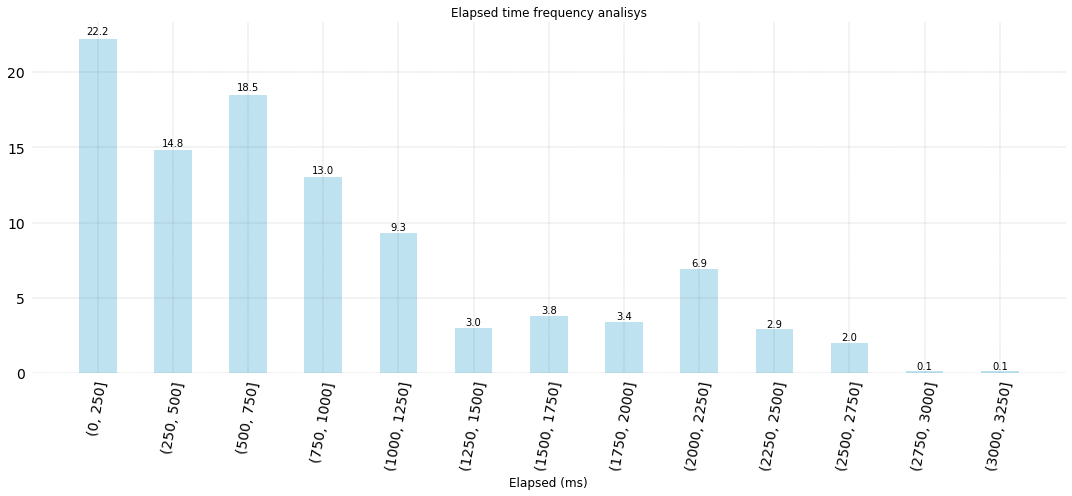

In [71]:


        
# Create the chart.
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

frequencies = config_elapsed_frequency_chart(type_of_elapsed_frequency_chart)
if frequencies[0] == Tr 
elapsed_frequency_chart(ax=ax[0], x=frequencies.index.astype(str), y=y)

plt.savefig(os.path.join(images_path,"{prefix}elapsed_frequency_chart.png".format(prefix=image_file_prefix)))


In [28]:
#
#
#
def transaction_per_second_chart(ax, x, y, colors=["#0000e6", "#d5d5d5", "#c87607"]):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
        ax.set_xlim(time_limits)

        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)
       
        ax.tick_params(axis='x', labelrotation=80)

        ax.set_title(labels["tps title"][0], fontsize=labels["tps title"][1])
        ax.set_ylabel(labels["tps y"][0], fontsize=labels["tps y"][1])
        ax.set_xlabel(labels["tps x"][0], fontsize=labels["tps x"][1])

        remove_tick_lines('x', ax)
        remove_tick_lines('y', ax)
        
        ax.step(x, y, color=colors[0])
        
    except Exception as ex:
        print("transaction_per_second_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv    

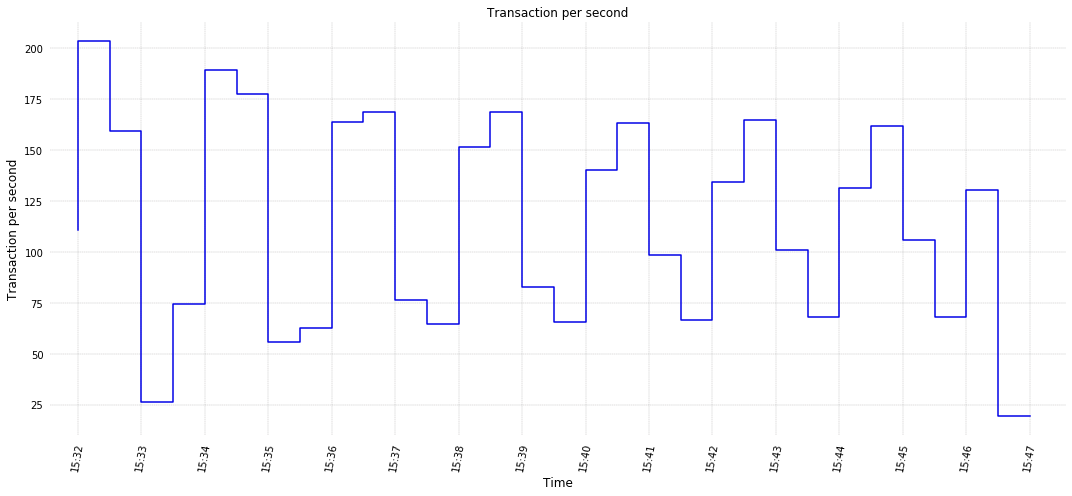

In [29]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

transaction_per_second_chart(ax[0]
                    ,x=binned_elapsed.index
                    ,y=binned_elapsed['tps'].values)

plt.savefig(os.path.join(images_path,"{prefix}transaction_X_second_chart.png".format(prefix=image_file_prefix)))


In [63]:
#
#
#
def text_box(ax, text, colors=["#FFFFFF", "#000000", "#c87607"], fontsize=14):
    """
    """
    rv = False
    try:
        ax.text(0, 0
               ,text
               ,bbox=dict(boxstyle = "square", facecolor = colors[0], edgecolor = "none")
               ,color = colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv    


def quantiles_box_text():
    """
    """
    txt = None
    rv = False
    try:
        txt = "{title}\n\n".format(title=labels["quantiles txt title"][0])
        for quantile, value in zip(global_statistics["quantiles elapsed"].index
                                  ,global_statistics["quantiles elapsed"].values):
            txt = txt + "{q}° => {v}\n".format(q=int((quantile*10)+1), v=int(value))
    except Exception as ex:
        print("statistics_box_text failed - {ex}".format(ex=ex))
    else:
        rv = True 
        
    return (rv, txt)

def statistics_box_text():
    """
    
    """
    dt_format = "%d/%m/%Y %H:%M"
    txt = None
    rv = False
    try:
        title = "{title}\n\n".format(title=labels["statistics txt title"][0])
        txt_duration = labels["stats duration"].format(be=global_statistics['test begin'].strftime(dt_format)
                                                      ,en=global_statistics['test end'].strftime(dt_format)
                                                      ,d=global_statistics['duration']) 

        txt_sample_num = labels["stats sample num"].format(n=f"{global_statistics['sample num']:,}"
                                                          ,er=f"{global_statistics['samples in error']:,}")
                                                           
        txt_elapsed = labels["stats elapsed"].format(min=global_statistics['min elapsed']
                                                    ,max=global_statistics['max elapsed']
                                                    ,avg=global_statistics['mean elapsed']
                                                    ,stde=global_statistics['std error elapsed']
                                                    ,med=global_statistics['median elapsed'])

        txt_threads = "\n" + labels["stats max threads"].format(th=global_statistics["max threads"])
                                                           
        txt = title + txt_duration + txt_sample_num + txt_elapsed + txt_threads
    except Exception as ex:
        print("statistics_box_text failed - {ex}".format(ex=ex))
    else:
        rv = True 
        
    return (rv, txt)

def picture_title_text(title):
    """
    """
    txt = None
    rv = False
    try:
        dt_format = "%d/%m/%Y %H:%M"                                                           
        txt = title + " - " + global_statistics['test begin'].strftime(dt_format)
    except Exception as ex:
        print("statistics_box_text failed - {ex}".format(ex=ex))
    else:
        rv = True 
        
    return (rv, txt)
                                                           


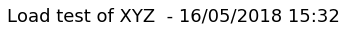

In [66]:

fig = plt.figure(figsize=(3.9, 0.5))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

text = picture_title_text(picture_title)
if text[0] == True:
    text_box(ax[0], text[1], fontsize=18)
    plt.savefig(os.path.join(images_path,"{prefix}pcture-title-tbox.png".format(prefix=image_file_prefix)))


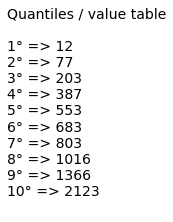

In [43]:

fig = plt.figure(figsize=(2, 3))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

text = quantiles_box_text()
if text[0] == True:
    text_box(ax[0], text[1])
    plt.savefig(os.path.join(images_path,"{prefix}quantiles-tbox.png".format(prefix=image_file_prefix)))


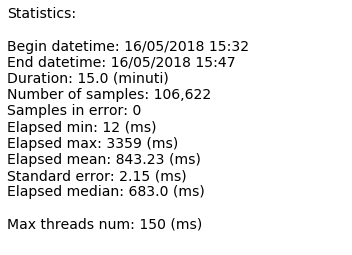

In [67]:
        
# --------------------------------------------
fig = plt.figure(figsize=(5, 3))
gs = fig.add_gridspec(1, 1)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

text = statistics_box_text()
if text[0] == True:
    text_box(ax[0], text[1])
    plt.savefig(os.path.join(images_path,"{prefix}statitstics-tbox.png".format(prefix=image_file_prefix)))


In [33]:
global_statistics

{'duration': 15.0,
 'max threads': 150,
 'test begin': Timestamp('2018-05-16 15:32:03.967000'),
 'test end': Timestamp('2018-05-16 15:47:03.839000'),
 'duration sec': 899.872,
 'transaction per second': 118.0,
 'sample num': 106622,
 'samples in error': 0,
 'max elapsed': 3359,
 'min elapsed': 12,
 'mean elapsed': 843.23,
 'median elapsed': 683.0,
 'std error elapsed': 2.15,
 'quantiles elapsed': 0.0      12.0
 0.1      77.0
 0.2     203.0
 0.3     387.0
 0.4     553.0
 0.5     683.0
 0.6     803.0
 0.7    1016.0
 0.8    1366.0
 0.9    2123.0
 Name: elapsed, dtype: float64}